# Biotic anthropogenic classification

Aim is to classify each moment in time as being:
    
- biotic/not biotic
- anthropogenic/not anthropogenic


We will use a separate model for each of these classifications

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os
import numpy as np

import scipy.io.wavfile
from scipy.io import loadmat
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import collections

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import features as engaged_features
from engaged.features import frequency


In [2]:
# getting a list of all the files
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files'
files = os.listdir(base_path + '/detection_challenge')
files = [xx.split('.')[0] for xx in files]

spectrogram_parameters = {
    'nfft': 1024,
    'window_width': 0.03,
    'overlap': 0.01,
    }

print len(files)

362


In [34]:
# for each file, compute features for each second and assign to biotic/not_biotic lists
# we will worry about anthropogenic later
all_data = {}

from scipy.ndimage.interpolation import zoom

max_files = 20

# maximum num slices of each class to take from each file
max_from_each_file = 100
files_to_use = files[:max_files]


def extract_features(spec, idxs, maximum=None):
    """
    returns a set of features from the spectrogram at points marked by idxs.
    If there are more idx locations than maximum, then will subsample idxs.
    """
    if maximum is not None and maximum < idxs.sum():
        idxs = np.random.choice(np.where(idxs)[0], maximum, replace=False)
        N = maximum
    else:
        N = idxs.sum()
        idxs = np.where(idxs)[0]
    
    if N == 0:
        return None
# #     2*(spec.shape[0]-1)/8 + 2)[:, None]
    
    sampled_spec = spec[:-1, idxs]
    new_height =  spec.shape[0] / 8
    max_features = sampled_spec.T.reshape((8, new_height, N)).max(axis=0)
    med_features = np.median(sampled_spec.T.reshape((8, new_height, N)), axis=0)
    
    max_pos = np.argmax(max_features, axis=0)[None, :]
    max_val = np.max(max_features, axis=0)[None, :]
    
    # take the maximum, mean, var across strips surrounding each idx
    substrip_means = [np.zeros((6*new_height))]
    substrip_maxs = [np.zeros((6*new_height))]
    substrip_vars = [np.zeros((6*new_height))]
    
    for idx in idxs:
        substrip = spec[:-1, idx-3:idx+3]
        substrip_reshaped = substrip.T.reshape((8, -1))
        substrip_maxs.append(substrip_reshaped.max(axis=0))
        substrip_means.append(substrip_reshaped.mean(axis=0))
        substrip_vars.append(substrip_reshaped.var(axis=0))
    
    substrip_maxs = np.hstack(substrip_maxs)
    substrip_means = np.hstack(substrip_means)
    substrip_vars = np.hstack(substrip_vars)

    return {
        'max_val': max_val,
        'max_pos': max_pos,
        'max_features': max_features,
        'med_features': med_features,
        'substrip_maxs': substrip_maxs,
        'substrip_vars': substrip_vars,
        'substrip_means': substrip_means,
        'num_idxs': N
    }

# max_features, med_features, max_pos,  
    
for count, fname in enumerate(files_to_use):
    
    # load in wav and convert to spectrogram
    sr, wav = scipy.io.wavfile.read(base_path + '/25_Random/' + fname + '.wav')  
    spec, spec_sample_rate = frequency.spectrogram(wav, sr, **spectrogram_parameters)
    spec -= np.median(spec, axis=1)[:, None]
#     spec[spec < 0] = 0
        
    # load in ground truth
    gt = loadmat(base_path + '/detection_challenge/' + fname + '.mat')
    
    # convert the labels to the sampling rate of the spectrogram
    zoom_factor = float(spec.shape[1]) / float(wav.shape[0])
    
    gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(bool)
    gt_anthrop = zoom(gt['anthropogenic'][0], zoom_factor).astype(bool)
        
    # group spec slices according to labels
    these_data = {}
    
    these_data['biotic'] = {
        'yes': extract_features(spec, gt_biotic, max_from_each_file),
        'no': extract_features(spec, ~gt_biotic, max_from_each_file)
        }
    
    these_data['anthrop'] = {
        'yes': extract_features(spec, gt_anthrop, max_from_each_file),
        'no': extract_features(spec, ~gt_anthrop, max_from_each_file)
        }
    
    all_data[fname] = these_data

    if count % 10 == 0:
        print count,

0 10


In [51]:
# compiling together the features for each experiment
class_to_use = 'biotic'

experiments = collections.OrderedDict([
    ('max_val', ['max_val']),
    ('max_pos', ['max_pos']),
    ('max_features', ['max_features']),
    ('med_features', ['med_features']),
    ('substrip_maxs', ['substrip_maxs']),
    ('substrip_vars', ['substrip_vars']),
    ('substrip_means', ['substrip_means']),
    ('all_single_strips', ['max_val', 'max_pos', 'max_features', 'med_features']),
    ('all_substrips', ['substrip_maxs', 'substrip_vars', 'substrip_means'])
])

import collections
X = collections.defaultdict(dict)
Y = {}

def flip(X):
    if X is None:
        return 0
    else:
        return X['num_idxs']
    
for experiment_name, features in experiments.iteritems():
    print "Doing ", experiment_name
    
#     test_X_yes = np.hstack([all_data[f][class_to_use]['yes'] for f in test_files]).T
    
    for fname in files_to_use:

        for subclass in ['yes', 'no']:
            
            # only add if there is some feature here at all...
            if all_data[fname][class_to_use][subclass] is not None:    
                
                X[fname][experiment_name] = np.vstack([
                    all_data[fname][class_to_use][subclass][feature] 
                    for feature in features])

for fname in files_to_use:

    Y[fname] = np.array([
            flip(all_data[fname][class_to_use]['yes']) * [1] + \
            flip(all_data[fname][class_to_use]['no']) * [0]
            ])


Doing  max_val
Doing  max_pos
Doing  max_features
Doing  med_features
Doing  substrip_maxs
Doing  substrip_vars
Doing  substrip_means
Doing  all_single_strips
Doing  all_substrips


In [52]:
all_data[fname][class_to_use]['yes']

In [53]:
# splitting into train and test sets
train_files, test_files = train_test_split(files_to_use, random_state=0)

In [60]:
# now split the data into training and test...
X_train = {}
X_test = {}
Y_train = []
Y_test = []

for experiment_name in experiments:
    
    X_train[experiment_name] = np.hstack([
            X[fname][experiment_name]
            for fname in train_files
        ])
    
    X_test[experiment_name] = np.hstack([
            X[fname][experiment_name]
            for fname in test_files
        ])
    
Y_test = np.hstack([Y[fname] for fname in test_files])

print Y_test.shape
print X_test['max_features'].shape

(1, 800)
(64, 500)


In [308]:
        

# let's just do biotic for now...
train_X_yes = np.hstack([all_data[f][class_to_use]['yes'] for f in train_files]).T
train_X_no = np.hstack([all_data[f][class_to_use]['no'] for f in train_files]).T

# balance...
num_to_use = min(train_X_yes.shape[0], train_X_no.shape[0])

def sample_rows(X, num_to_sample):
    """samples rows without replacement. If shape[0] < num_to_sample, just returns X"""
    if X.shape[0] > num_to_sample:
        idxs = np.random.choice(X.shape[0], num_to_sample, replace=False)
        return X[idxs, :]
    else:
        return X
    
train_X_yes = sample_rows(train_X_yes, num_to_use)
train_X_no = sample_rows(train_X_no, num_to_use)

train_X = np.vstack((train_X_yes, train_X_no))
train_Y = np.array((train_X_yes.shape[0] * [1]) + (train_X_no.shape[0] * [0]))

test_X_yes = np.hstack([all_data[f][class_to_use]['yes'] for f in test_files]).T
test_X_no = np.hstack([all_data[f][class_to_use]['no'] for f in test_files]).T

test_X_yes = sample_rows(test_X_yes, 1000)
test_X_no = sample_rows(test_X_no, 1000)

test_X = np.vstack((test_X_yes, test_X_no))
test_Y = np.array((test_X_yes.shape[0] * [1]) + (test_X_no.shape[0] * [0]))

print train_X_yes.shape
print train_X_no.shape
print train_X.shape
print train_Y.shape

print test_X_yes.shape
print test_X_no.shape
print test_X.shape
print test_Y.shape

# balance the training dataset...

(91527, 2)
(91527, 2)
(183054, 2)
(183054,)
(1000, 2)
(1000, 2)
(2000, 2)
(2000,)


In [309]:
# now train a classifier
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, n_jobs=8, max_features=None)
rf.fit(train_X, train_Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

[[ 0.76  0.24]
 [ 0.02  0.98]
 [ 0.3   0.7 ]
 ..., 
 [ 0.32  0.68]
 [ 0.98  0.02]
 [ 0.62  0.38]]


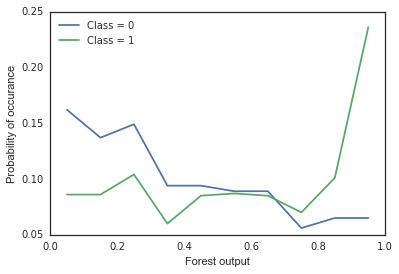

In [310]:
# test the classifier
pred_Y = rf.predict(test_X)
pred_Y_probs = rf.predict_proba(test_X)
print pred_Y_probs
edges = np.linspace(0, 1, 11)
Y0, X0 = np.histogram(pred_Y_probs[test_Y==0, 1], edges)
Y1, X1 = np.histogram(pred_Y_probs[test_Y==1, 1], edges)
plt.plot(X0[:-1]+0.05, Y0.astype(float) / Y0.sum(), label="Class = 0")
plt.plot(X1[:-1]+0.05, Y1.astype(float) / Y1.sum(), label="Class = 1")
plt.xlim(0, 1)
plt.ylabel('Probability of occurance')
plt.xlabel('Forest output')
plt.legend(loc='best')

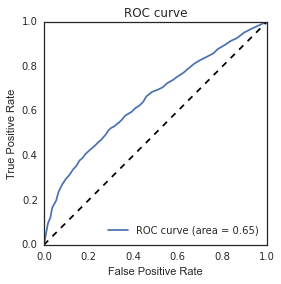

In [311]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_Y, pred_Y_probs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr , label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.gca().set_aspect('equal', adjustable='box')

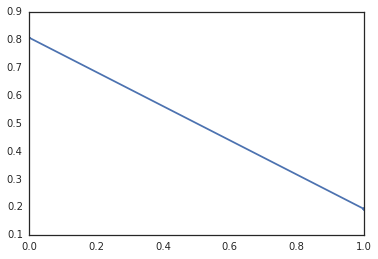

In [312]:
plt.plot(rf.feature_importances_, '.-')

[[651 349]
 [440 560]]


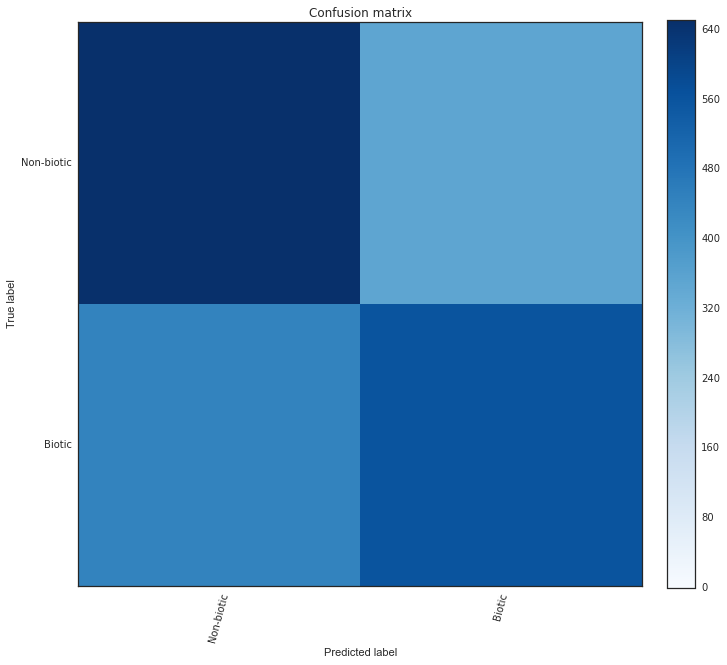

In [313]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set_style("white")

labels = ['Non-biotic', 'Biotic']
cm = confusion_matrix(test_Y, (pred_Y>0.5).astype(int))

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=75)
    
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print cm
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm);
plt.clim(0, cm.max())

In [314]:
print test_Y.shape
print test_Y.sum()
print pred_Y.shape
print (pred_Y>0).sum()

(2000,)
1000
(2000,)
909


In [330]:

def default(arg=None):
    if arg is not None:
        print arg
    else:
        print "No args"
        
default(np.array([3, 4, 1]))
default('df')
default()

[3 4 1]
df
No args
